In [2]:
using Revise
using NonEquilibriumGreenFunction
using HssMatrices
using LinearAlgebra
using CairoMakie
using LaTeXStrings
using BenchmarkTools
#HSS compression does not leverage efficiently the BLAS multithreading. 
#It is better to turn it off
BLAS.set_num_threads(1)

In [3]:
module Junction
using Revise
using NonEquilibriumGreenFunction
using LinearAlgebra
struct Parameters
    δt::Float64 #timestep
    T::Float64  #simulation length
    Γl::Float64 #left tunneling rate
    Γr::Float64 #right tunneling rate
    β::Float64  #inverse temperature
    ϕl # left phase
    ϕr # right phase
end
default_compression() = HssCompression(leafsize=32)
function Parameters(; δt, T, Γl=1, Γr=1, β=1, ϕl, ϕr)
    return Parameters(δt, T, Γl, Γr, β, ϕl, ϕr)
end
axis(p::Parameters) = 0:p.δt:p.T
function simulate_junction(p::Parameters; cpr = default_compression())
    #retarded
    Σ_R_right = dirac_kernel(Retarded(), axis(p), t -> -1im * p.Γr, compression=cpr)
    Σ_R_left = dirac_kernel(Retarded(), axis(p), t -> -1im * p.Γl, compression=cpr)
    Σ_R = Σ_R_left + Σ_R_right
    g = discretize_retardedkernel(axis(p), (t, tp) -> ComplexF64(-1im), compression=cpr, stationary=true)
    G_R = solve_dyson(g, g * Σ_R)
    #kinetic 
    ρ = discretize_acausalkernel(axis(p), (t, tp) -> thermal_kernel(t - tp, p.β) .|> ComplexF64,
        stationary=true, compression=cpr)
    coupling_left = dirac_kernel(Acausal(), axis(p), t -> sqrt(p.Γl)*exp(1im*p.ϕl(t)), compression=cpr)
    coupling_right = dirac_kernel(Acausal(), axis(p), t -> sqrt(p.Γr)*exp(1im*p.ϕr(t)), compression=cpr)
    Σ_K_left = coupling_left'*ρ*coupling_left
    Σ_K_right = coupling_right'*ρ*coupling_right
    Σ_K = Σ_K_left + Σ_K_right
    G_K = G_R*Σ_K*G_R'
    return (;G_R,G_K)
end
function dot_G_K(G::Kernel, p::Parameters)
    discretize_acausalkernel(axis(p), (t, tp) -> thermal_kernel(t - tp, p.β) * pauli(0) .|> ComplexF64,
        stationary=true, compression=default_compression())
end
end

Main.Junction

# Equilibrium simulation

In [4]:
p = Junction.Parameters(δt=0.1, T=100, ϕl=t -> 0, ϕr=t -> 1);
println("N = $(Junction.axis(p)|> length)")
results = Junction.simulate_junction(p,cpr = NONCompression());

N = 1001


In [5]:
function plot_results_maps(results)
    f = Figure()
    #retarded Green function
    f_ax = Axis(f[1, 1], title=L" \Im \left[ G^R(t,t')\right]",xlabel=L"t", ylabel=L"t'")
    G_R = matrix(results[:G_R]) |> full
    ax = Junction.axis(p) |> collect
    im_G_R = imag.(G_R)
    hm = heatmap!(f_ax, ax,ax, im_G_R)
    Colorbar(f[1, 2], hm)
    f_ax = Axis(f[1, 3], title=L"\Re \left[ G^R(t,t')\right]",xlabel=L"t", ylabel=L"t'")
    re_G_R = real.(G_R)
    hm = heatmap!(f_ax, ax,ax, im_G_R)
    Colorbar(f[1, 4], hm)
    #Keldysh Green function
    f_ax = Axis(f[2, 1], title=L" \Im \left[ G^K(t,t')\right]",xlabel=L"t", ylabel=L"t'")
    G_K = matrix(results[:G_K]) |> full
    ax = Junction.axis(p) |> collect
    im_G_K = imag.(G_K)
    hm = heatmap!(f_ax, ax,ax, im_G_K)
    Colorbar(f[2, 2], hm)
    f_ax = Axis(f[2, 3], title=L"\Re \left[ G^K(t,t')\right]",xlabel=L"t", ylabel=L"t'")
    re_G_K = real.(G_K)
    hm = heatmap!(f_ax, ax,ax, im_G_K)
    Colorbar(f[2, 4], hm)

    f
end
#We do not want to plot the full map for large simulation. 
#It would blow up the memory. 
if length(Junction.axis(p)) < 2001 
    plot_results_maps(results)
end

MethodError: MethodError: no method matching full(::Matrix{ComplexF64})
Closest candidates are:
  full(!Matched::HssMatrix{T}) where T at ~/.julia/packages/HssMatrices/oqOP8/src/hssmatrix.jl:270

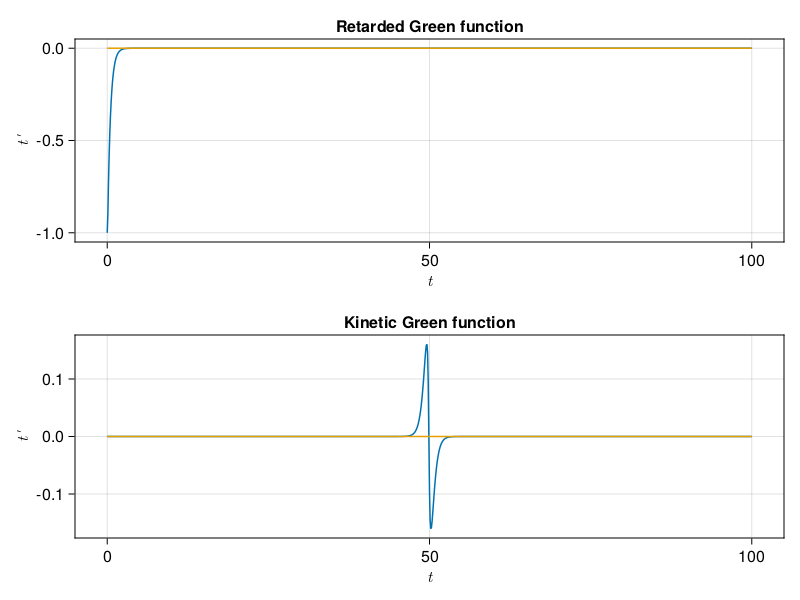

In [6]:
function plot_results(results)
    f = Figure()
    #retarded Green function
    f_ax = Axis(f[1, 1], title="Retarded Green function",xlabel=L"t", ylabel=L"t'")
    G_R = results[:G_R]
    ax = Junction.axis(p) |> collect
    im_G_R = reshape(imag.(vcat(discretization(G_R)[:, 1]...)), :)
    lines!(f_ax, ax, im_G_R)
    re_G_R = reshape(real.(vcat(discretization(G_R)[:, 1]...)), :)
    lines!(f_ax, ax, re_G_R)
    #Keldysh Green function
    G_K = results[:G_K]
    ax = Junction.axis(p) |> collect
    im_G_K = reshape(imag.(vcat(discretization(G_K)[:, length(ax) ÷ 2]...)), :)
    f_ax = Axis(f[2, 1], title="Kinetic Green function",xlabel=L"t", ylabel=L"t'")
    lines!(f_ax, ax, im_G_K)
    re_G_K = reshape(real.(vcat(discretization(G_K)[:, length(ax) ÷ 2]...)), :)
    lines!(f_ax, ax, re_G_K)
    f
end
plot_results(results)

## Benchmarks 
We benchmark the full resolution increasing simulation length, including the initial construction of the different kernels. 

In [7]:
tab_T_hss = p.δt .* [2^k for k = 6:2:14]
function benchmark_equilibrium_hss(T)
    p = Junction.Parameters(δt=0.1, T=T, ϕl=t -> 0, ϕr=t -> 0);
    @benchmark Junction.simulate_junction($p);
end
benchmark_equilibrium_results_hss = benchmark_equilibrium_hss.(tab_T)

UndefVarError: UndefVarError: tab_T not defined

In [8]:
tab_T_hss = p.δt .* [2^k for k = 4:2:16]
function benchmark_equilibrium_hss(T)
    p = Junction.Parameters(δt=0.1, T=T, ϕl=t -> 0, ϕr=t -> 0);
    @benchmark Junction.simulate_junction($p);
end
benchmark_equilibrium_results_hss = benchmark_equilibrium_hss.(tab_T_hss)

7-element Vector{BenchmarkTools.Trial}:
 570.000 μs
 4.404 ms
 19.441 ms
 101.360 ms
 471.928 ms
 1.982 s
 10.115 s

In [9]:
tab_T_full = p.δt .* [2^k for k = 4:2:10]
function benchmark_equilibrium_full(T)
    p = Junction.Parameters(δt=0.1, T=T, ϕl=t -> 0, ϕr=t -> 0);
    @benchmark Junction.simulate_junction($p,cpr = NONCompression());
end
benchmark_equilibrium_results_full = benchmark_equilibrium_full.(tab_T_full)

4-element Vector{BenchmarkTools.Trial}:
 106.750 μs
 961.417 μs
 35.728 ms
 1.957 s

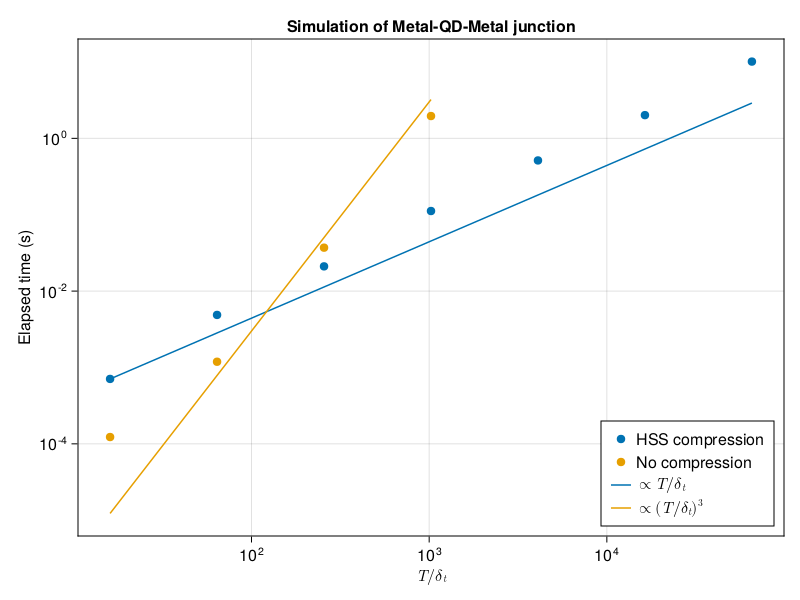

In [10]:
function plot_equilibrim_benchmark(tab_T_hss, results_hss, tab_T_full, results_full)
    f = Figure()
    f_ax = Axis(f[1, 1], xscale = log10, yscale = log10,
    title = "Simulation of Metal-QD-Metal junction",
    xlabel=L"T/\delta_t",
    ylabel="Elapsed time (s)")
    scatter!(f_ax, tab_T_hss / p.δt, map(results_hss) do x
        median(x.times) * 1E-9
    end,
    label = "HSS compression"
    )
    scatter!(f_ax, tab_T_full / p.δt, map(results_full) do x
        median(x.times) * 1E-9
    end,
    label = "No compression"
    )
    lines!(f_ax,tab_T_hss / p.δt, tab_T_hss ./ tab_T_hss[1] .* median(results_hss[1].times) * 1E-9, 
    label = L"\propto T/\delta_t"  )
    lines!(f_ax,tab_T_full / p.δt , tab_T_full.^3 ./ tab_T_full[1]^3 .* median(results_full[1].times) * 1E-10,
    label = L"\propto (T/\delta_t)^3"  )
    axislegend(position = :rb)
    f
end
f = plot_equilibrim_benchmark(
    tab_T_hss,
    benchmark_equilibrium_results_hss,
    tab_T_full,
    benchmark_equilibrium_results_full
)
save("equilibrium_benchmark.svg",f)
f